In [9]:
#%pip install "pytorch-lightning" "torchvision" "seaborn" "torchmetrics" "matplotlib" "torch" "ipython[notebook]" "pandas" --upgrade

In [3]:
#%pip install seaborn

In [4]:
#%pip install -r ./requirements.txt

In [5]:
import utils
from utils import seed_worker

# standard os libraries
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## PyTorch Lightning
#import pytorch_lightning as pl
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

## Setting the seed
#pl.seed_everything(42)

## Ensure that all operations are deterministic on GPU (if used) for reproducibility
#torch.backends.cudnn.determinstic = True
#torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [6]:
dataset_fpath='./datasets/files_valid/Trajectorys2_72_2000_anom.csv'
class_label = {'abnormal': 1, 'normal': 0}
col_grpID='Entity'
col_label='Label'
cols_seq=['Step']
cols_feat=['X_Coord', 'Y_Coord']
cols_X = cols_seq+[col_grpID]+cols_feat
cols_y = cols_seq+[col_grpID]+[col_label]

scaler = 'robust'  # 'robust', 'standard', None

df = pd.read_csv(dataset_fpath)
X = df[cols_X].set_index(cols_seq)
y = df[cols_y].set_index(cols_seq)

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X.reset_index(inplace=True)
X.set_index(cols_seq+[col_grpID], inplace=True)

if scaler == 'standard':
    X_sc = StandardScaler().fit_transform(X)
elif scaler == 'robust':
    X_sc = RobustScaler().fit_transform(X)
else:
    X_sc = X.to_numpy()
    
X_sc = pd.DataFrame(X_sc, index=X.index, columns=cols_feat).reset_index()
X_sc

,Step,Entity,X_Coord,Y_Coord
0,0,1,-0.943662,-0.711538
1,0,2,-0.915493,-0.576923
2,0,3,-0.915493,-0.769231
3,0,4,-0.943662,-0.634615
4,0,5,-0.943662,-0.673077
...,...,...,...,...
143995,71,1996,1.126761,0.711538
143996,71,1997,1.239437,0.153846
143997,71,1998,1.084507,0.230769
143998,71,1999,1.112676,0.980769


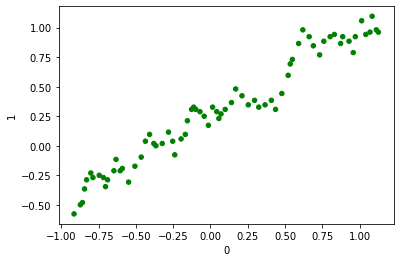

In [8]:
X_new=[]
y_new=[]
for grpid in X_sc[col_grpID].unique():
    X_new.append(X_sc.query(f"{col_grpID} == {grpid}")[cols_feat])
    y_new.append(y.query(f"{col_grpID} == {grpid}")[col_label][0])
X_new=np.array(X_new)
y_new=np.array(y_new)


plot_grpidx_normal   = y.query(f"{col_label} == {class_label['normal']}")[col_grpID].iloc[0]
plot_grpidx_abnormal = y.query(f"{col_label} == {class_label['abnormal']}")[col_grpID].iloc[0]

plot_idx=plot_grpidx_normal # plot_grpidx_abnormal , plot_grpidx_normal

plot_grp = y.query(f"{col_grpID} == {plot_idx}")
plot_clr = ['g' if y_ == 0 else 'r' for y_ in plot_grp[col_label]]
pd.DataFrame(X_new[plot_idx]).plot.scatter(x=0,y=1,c=plot_clr)

X = torch.tensor(X_new)
y = torch.tensor(y_new)

# trajectories, sequence-step, entity_features
# X_new.shape # (2000, 72, 2)
# y_new.shape # (2000,)

In [9]:
def scaled_dot_product(q, k, v, mask=None): # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

x=X

m = x.shape[0] # samples
n = x.shape[1] # seq_len (trajectory steps - concatenated sample features)
f = x.shape[2] # entity step features
# torch.Size([2000, 72, 2])


m = 2000
num_heads = 8

d_inp_size = 72 # n
d_step_feat = f # f
d_inp_embed_size = 1 # 1
h = 8 # num heads
d_k = 8 # d_q = d_k = d_v # 72 - todo: 8, 16, 32, 512, 2048
d_ffn_embed_size = 2048 # (Vaswani et al.)
d_qkv = 3*d_k # 216 # 1536

inp_emb = nn.Linear(f, d_inp_embed_size)
inp_prj = nn.Linear(d_inp_size, d_k)
qkv_prj = nn.Linear(d_k, h * d_qkv) # MHA
out_prj = nn.Linear(h, d_inp_embed_size)

In [10]:
x = X
x = x.float()
#q,k,v = x,x,x
print(x.dtype)
x.shape

torch.float32


torch.Size([2000, 72, 2])

In [11]:
def freeze_weights(model, param_name, unfreeze, verbose=False):
    for a, b in model.named_parameters():
        if param_name in a:
            b.requires_grad=unfreeze
            if verbose: print(b)

class InputEmbedding(nn.Module):
    
    def __init__(self, d_inp_size, d_step_feat, d_inp_embed_size, static_encoding=False):
        super(InputEmbedding, self).__init__()
        
        self.d_k = d_inp_size # d_k # 72 # trajectory steps
        self.d_step_feat = d_step_feat # 2
        self.d_inp_embed_size = d_inp_embed_size # 8
        
        # from input_net (input_dim -- prj -> model_dim)
        # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (image) vs gadf (trajectory)
        # student: input adaption to trajectories
        
        self.inp_prj_feat = nn.Linear(d_step_feat, d_inp_embed_size)
        
        # for future transformer layer capability investigation
        #if static_encoding:
        #    freeze_weights(self, 'inp_prj_feat', unfreeze=False)
        #    #freeze_weights(self, 'inp_prj_grp', unfreeze=False)
        #else:
        #    freeze_weights(self, 'inp_prj_feat', unfreeze=True)
        #    #freeze_weights(self, 'inp_prj_grp', unfreeze=True)
        
    def forward(self, x):
        
        # x - torch.Size([2000, 72, 2])
        # m = x.shape[0] #bs
        
        x1 = self.inp_prj_feat(x) # torch.Size([2000, 72, 8])      
        
        return x1  

In [12]:
d_inp_size = 72 # d_k = 72 # d_model
d_inp_embed_size = 8
d_step_feat = 2
d_k = d_inp_size

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)
x1.shape # torch.Size([2000, 72, 8]) - v1: torch.Size([2000, 72, 1]) v2: torch.Size([2000, 72, 8])

/tmp/ipykernel_729/2828342101.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])


torch.Size([2000, 72, 8])

In [13]:
import time

In [14]:
class SHAtt(nn.Module):
    
    def __init__(self, d_k, d_model, d_inp_embed_size, winit_orig=True):
        super(SHAtt, self).__init__()
        
        # v2: d_inp_size = d_k = d_model = n
        self.d_k = d_k # ( Vaswani et al. -> d_q = d_k = d_v = d_model ) = 32, 512, 2048  
        self.d_model = d_model 
        
        # v2: 8 = projected group member (traj-step) features f (8 originated from LightningTutorialVersion with further hyperparameter search - others 4, 16, 72, 100, etc.) 
        # v1: 1 = embedded group member (traj-step) features f      
        self.d_inp_embed_size = d_inp_embed_size 
        self.d_qkv = 3*d_model
        
        if winit_orig is None or winit_orig:
            self.fc_qkv = nn.Linear(d_k, self.d_qkv, bias=True) # SHA
        else:
            self.fc_qkv = nn.Linear(d_k, self.d_qkv, bias=False) # Karpathy et al. (-> d_k != d_model, d_k=d_inp_size, d_model=d_model)
        
        self._reset_parameters(winit_orig)
        

    def _reset_parameters(self, winit_orig=True):
        if winit_orig is not None:
            # Original Transformer initialization, see PyTorch documentation
            if winit_orig:
                # https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (LightningTutorialVersion)
                nn.init.xavier_uniform_(self.fc_qkv.weight)
                self.fc_qkv.bias.data.fill_(0)
            else:
                # Karpathy et al.
                nn.init.normal_(self.fc_qkv.weight, mean=0., std=np.sqrt(2/(self.d_k+self.d_model)))

    def scaled_dot_product(self, q, k, v, mask=None):
        # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (LightningTutorialVersion)
        d_k = q.size()[-1]
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / math.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        attention = F.softmax(attn_logits, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention
        
    def forward(self, x):
        
        # x - torch.Size([2000,  72, 8])
        # x - torch.Size([2000, d_k, 8])
        
        m = x.shape[0] # number of groups in batch = bs
        
        x1 = x.reshape(m, self.d_inp_embed_size, self.d_k)    # v2: torch.Size([2000, 8, 72])  v1: torch.Size([2000, 1, 72])
        x2 = self.fc_qkv(x1)                                  # v2: torch.Size([2000, 8, 216]) v1: torch.Size([2000, 1, 216]) - d_model = d_inp_size = 72 (fc_qkv: 3*d_model)
        
        q = x2[:, :, :self.d_model].reshape(m, self.d_model, self.d_inp_embed_size)               # v2: torch.Size([2000, d_model, 8]) - d_model=d_q , v1: torch.Size([2000, 72, 1])
        k = x2[:, :, self.d_model:2*self.d_model].reshape(m, self.d_model, self.d_inp_embed_size) # v2: torch.Size([2000, d_model, 8]) - d_model=d_k , v1: torch.Size([2000, 72, 1])
        v = x2[:, :, 2*self.d_model:].reshape(m, self.d_model, self.d_inp_embed_size)             # v2: torch.Size([2000, d_model, 8]) - d_model=d_v , v1: torch.Size([2000, 72, 1])
        
        out, att = self.scaled_dot_product(q, k, v, mask=None) # v2: torch.Size([2000, d_model, 8]) v1: torch.Size([2000, 72, 1]) , att - torch.Size([2000, d_model, d_model])
        
        return out, att
  
    
d_inp_size = 72 # d_k = 72 # d_model
d_inp_embed_size = 8


shatt1 = SHAtt(d_k=d_inp_size, d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
shatt2 = SHAtt(d_k=d_inp_size, d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
out1, attn1 = shatt1(x1)
out2, attn2 = shatt2(x1)
print(f"out: {out1.shape} - attn: {attn1.shape}")  # out: torch.Size([2000, 72, 8]) - attn: torch.Size([2000, 72, 72])

out: torch.Size([2000, 72, 8]) - attn: torch.Size([2000, 72, 72])


In [15]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, d_inp_embed_size):
        super(PositionalEncoding, self).__init__()
        
        # d_inp_size = d_model = d_k
        
        self.pe = torch.zeros(d_inp_embed_size, d_model) # 8, 72        
        self.pe.requires_grad = False
        
        for pos in range(0, d_inp_embed_size): 
            for i in range(0, d_model):
                
                if 2*i < d_k: denom = 10000. ** (2*i/d_model)    
                if 2*i < d_k: self.pe[pos,2*i] = math.sin( pos / denom )
                if 2*i+1 < d_k: self.pe[pos,2*i+1] = math.cos( pos / denom )
                    
        self.pe = self.pe.reshape(d_model, d_inp_embed_size) # 72, 8
                    
        #self.register_buffer("pe", pe, persistent=False)
        
    def to(self, device):
        self.pe = self.pe.to(torch.device(device))
        return self
        
    def forward(self, x, **kwargs):
        return self.pe[:, :x.size(1)] # 72, 8
    

d_inp_size = 72 # d_k = 72 # d_model
d_inp_embed_size = 8
d_step_feat = 2
d_k = d_inp_size

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)
x1.shape # torch.Size([2000, 72, 8])

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)
pos_enc.shape # torch.Size([72, 8])

x2 = x1 + pos_enc
x2.shape

/tmp/ipykernel_729/3968662628.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])


torch.Size([2000, 72, 8])

<AxesSubplot: >

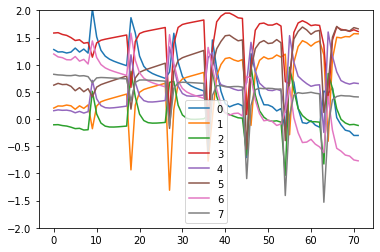

In [16]:
x1.shape #v1: 2000, 72, 1, v2: 2000, 72, 8
x2.shape #v1: 2000, 72, 1, v2: 2000, 72, 8
sid=7
pd.DataFrame(x2[sid].detach().cpu().numpy(), list(range(0,x2.shape[1]))).plot(ylim=[-2,2])

In [17]:
class MHAtt(nn.Module):
    
    def __init__(self, d_k, d_model, d_inp_embed_size, num_heads, save_attn=False, winit_orig=True):
        super(MHAtt, self).__init__()
        
        self.d_k = d_k
        self.d_model = d_model        
        self.d_inp_embed_size = d_inp_embed_size
        self.num_heads = num_heads
        self.save_attn = save_attn
        
        
        self.mha = nn.Sequential(
            *[SHAtt(d_k, d_model, d_inp_embed_size, winit_orig) for _ in range(0,self.num_heads)]
        )
        
        if winit_orig is None or winit_orig:
            self.fc_out = nn.Linear(num_heads * d_model, d_k, bias=True) # original (tutorial)
        else:
            self.fc_out = nn.Linear(num_heads * d_model, d_k, bias=False) # no bias - Karpathy et al.
            
        self._reset_parameters(winit_orig)

    def _reset_parameters(self, winit_orig=True):
        # Original Transformer initialization, see PyTorch documentation
        if winit_orig is not None:
            if winit_orig:
                nn.init.xavier_uniform_(self.fc_out.weight)
                self.fc_out.bias.data.fill_(0)
            else:
                # Karpathy et al.
                nn.init.normal_(self.fc_out.weight, mean=0., std=np.sqrt(2/(self.d_inp_size+self.d_k)))

    def forward(self, x):
        
        m = x.shape[0] #bs
        attn=[]
        x_=None
        
        for h in range(0, self.num_heads):
            
            out, att = self.mha[h].forward(x)            
            if x_ is None:
                x_ = out
            else:
                x_ = torch.concat([x_, out])
            if self.save_attn: attn.append(att.clone().detach().cpu().numpy())
        
        # e.g. 
        # num_heads=1: num_heads * out: torch.Size([2000,         1 *      72,  8]) - attn: torch.Size([2000, 72, 72])
        # num_heads=1: num_heads * out: torch.Size([2000, num_heads * d_model,  8]) - attn: torch.Size([2000, d_model, d_model])
        # ...
        
        x_ = x_.reshape(m, self.d_inp_embed_size, self.num_heads * self.d_model) 
        # num_heads=1: torch.Size([2000, 8, num_heads * d_model]) 
        
        o = self.fc_out(x_) # torch.Size([2000, 8, d_k])         
                
        o = o.reshape(m, self.d_k, self.d_inp_embed_size) 
        
        # o - torch.Size([2000,  72, 8])
        # o - torch.Size([2000, d_k, 8])
        
        return o, attn
    
# x3 = x2 + pos_enc # -> torch.Size([2000, 72, 8])

d_inp_size = 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

mh = MHAtt(d_k, d_model, d_inp_embed_size, num_heads, save_attn=True, winit_orig=True)
o, attn = mh.forward(x2)  # o.shape - torch.Size([2000, d_k, 8]) ,  attn - list of num_heads * (2000, d_model, d_model)
o.shape # torch.Size([2000, 72, 8])

/tmp/ipykernel_729/2627855895.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])


torch.Size([2000, 72, 8])

In [18]:
class TransformerEncoderBlockLayer(nn.Module):
    
    def __init__(self, d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, dropr=0.0, save_attn=True, winit_orig=True):
        super(TransformerEncoderBlockLayer, self).__init__()
        
        self.d_inp_size = d_inp_size
        self.d_inp_embed_size = d_inp_embed_size
        self.d_ffn_embed_size = d_ffn_embed_size
        self.d_k = d_k
        self.num_heads = num_heads
        self.save_attn = save_attn
        #self.attn = []
        self.attn = None
        
        self.energies = {'trn': {}, 'vld': {}}
        
        self.mh_att = MHAtt(d_k, d_model, d_inp_embed_size, num_heads, save_attn, winit_orig)
        self.dropout = nn.Dropout(dropr) # to check
        self.layer_norm1 = nn.LayerNorm([d_k, d_inp_embed_size]) #to check
        self.layer_norm2 = nn.LayerNorm([d_k, d_inp_embed_size])
        self.ffn = nn.Sequential(
            nn.Linear(d_k, d_ffn_embed_size),
            nn.Dropout(dropr), # to check
            nn.Tanh(), # nn.ReLU() (Vaswani et al.)
            nn.Linear(d_ffn_embed_size, d_k),
            nn.Dropout(dropr) # to check
        )       
    
        
    def log_energies(self, key, ep, x):
        
        phase = ('vld','trn')[self.training]        
        if key not in self.energies[phase].keys():
            self.energies[phase][key] = {}
        if ep not in self.energies[phase][key].keys():                
            self.energies[phase][key][ep] = []    
        self.energies[phase][key][ep].append(x)
        
    #def forward_norm_after(self, x, ep, blidx): # original
    def forward(self, x, ep, blidx):
        
        m = x.shape[0] # bs
        
        x0, self.attn = self.mh_att(x)
        
        self.log_energies(f"o_mha{blidx}", ep, x0.clone().detach().cpu().numpy())
        
        # x - torch.Size([2000,  72, 8])
        # x - torch.Size([2000, d_k, 8])
        # x0 - torch.Size([2000, 72, 8])
        # x0 - torch.Size([2000, d_k, 8])
        
        # x1 = self.dropout(x0) # to check (source: student)
        x2 = self.layer_norm1(x + x0) # Add & Norm - v2: torch.Size([2000, d_k, 8]) vs v1: torch.Size([2000, d_k, 1])
        
        self.log_energies(f"i_ffn{blidx}", ep, x2.clone().detach().cpu().numpy())        
        
        x3 = x2.reshape(m, self.d_inp_embed_size, self.d_k) # v2: torch.Size([2000, 8, d_k]) vs v1: torch.Size([2000, 1, d_k])
        
        x4 = self.ffn(x3)                                   # v2: torch.Size([2000, 8, d_k]) vs v1: torch.Size([2000, 1, d_k])
        
        self.log_energies(f"o_ffn{blidx}", ep, x4.clone().detach().cpu().numpy())
        
        x5 = x4.reshape(m, self.d_k, self.d_inp_embed_size) # v2: torch.Size([2000, d_k, 8]) vs v1: torch.Size([2000, d_k, 1])
        
        x6 = self.layer_norm2(x5 + x2) # Add & Norm - v2: torch.Size([2000, d_k, 8]) vs v1: torch.Size([2000, d_k, 1])
        
        self.log_energies(f"o_nrm{blidx}", ep, x6.clone().detach().cpu().numpy())
                
        return x6
                
    def forward_norm_upfront(self, x):
    #def forward(self, x, ep, blidx):
        
        m = x.shape[0] # bs
        
        x1 = self.layer_norm1(x) # Norm - torch.Size([256, 32, 1])
        x2, self.attn = self.mh_att(x1)
        # x1 = self.dropout(x0) # to check
        x3 = x2 + x1  # Add &
        x4 = self.layer_norm2(x3) # Norm - torch.Size([256, 32, 1])
        x5 = x4.reshape(m, self.d_inp_embed_size, self.d_k) # torch.Size([256, 1, 32])
        x6 = self.ffn(x5)
        x7 = x5 + x6 # Add & 
        x8 = x7.reshape(m, self.d_k, self.d_inp_embed_size)

        return x8
        

d_inp_size = 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

enc_block = TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads)
lo = enc_block.forward(x2, 0, 0)
lo.shape # v2: torch.Size([2000, 72, 8]), v1: torch.Size([2000, 72, 1])

/tmp/ipykernel_729/2931634648.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])


torch.Size([2000, 72, 8])

In [19]:
class CustomTaskHead(nn.Module):
        
    def __init__(self, d_k, d_inp_embed_size, num_nonlinearity_layers=2, dropr=0.):        
        super(CustomTaskHead, self).__init__()
        
        self.d_k = d_k
        self.d_inp_embed_size = d_inp_embed_size
        self.dropr = dropr
        self.num_nonlinearity_layers = num_nonlinearity_layers
        
        # before:
        # nn.Linear(d_k, d_k),
        # #nn.ReLU(), 
        # reshape
        # nn.Linear(d_k, d_k),
        # nn.ReLU(),
        # nn.Dropout(dropr),
        # nn.Linear(d_inp_embed_size, 1)
        
        # nn.Linear(d_k, d_k),            # torch.Size([2000, 72, 8])
        # nn.ReLU(),                      # afterwards
        # reshape(m, 8, d_k),             # before
        # nn.Linear(d_k, d_k),            # torch.Size([2000, 72, 8])
        # nn.ReLU(),                      # before
        ## nn.Dropout(dropr),              # before
        # nn.Linear(d_inp_embed_size, 1)  # torch.Size([2000, 72, 1])
        # reshape(m, 1, d_k),             # after
        # nn.Linear(d_k, 1)               # torch.Size([2000, 1, 1])
        # nn.Dropout(dropr),              # after
        
        self.task_nonlinearity_layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(d_k, d_k),            # torch.Size([2000, 72, 8])
                nn.ReLU()                      # afterwards (first relu added)
            ) for _ in range(0, num_nonlinearity_layers)
        ])
        
        self.prj_inp_embed = nn.Linear(d_inp_embed_size, 1)  
        self.prj_d_k = nn.Linear(d_k, 1)
        self.dropout = nn.Dropout(dropr)
        
    def forward(self, x):
        
        m = x.shape[0] # bs
        # v2: x - torch.Size([2000, 8, 72]) m, d_inp_embed_size, d_k
        
        x_ = x 
        
        for lidx in range(0, self.num_nonlinearity_layers):
            
            # x_ - torch.Size([2000, 8, 72])
            x_ = self.task_nonlinearity_layers[lidx](x_)        # torch.Size([2000, 72, 8])
            x_ = x_.reshape(m, self.d_inp_embed_size, self.d_k) # torch.Size([2000, 8, 72])
            
        x1 = x_.reshape(m, self.d_k, self.d_inp_embed_size)     # torch.Size([2000, 72, 8])
        ##x1 = self.dropout(x1)                                 # before
        x2 = self.prj_inp_embed(x1)                             # torch.Size([2000, 8, 1])        
        x3 = x2.reshape(m, 1, self.d_k)                         # torch.Size([2000, 1, 72])        
        x4 = self.prj_d_k(x3)                                   # torch.Size([2000, 1, 1])        
        x5 = self.dropout(x4)                                   # after
        
        return x5

d_inp_size = 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

# actually for-loop here but just for code testing
enc_block = TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads)
x3 = enc_block.forward(x2, 0, 0)

x4 = x3.reshape(m, d_inp_embed_size, d_k) # v2: torch.Size([2000, 8, 72])
x4.shape # x4 - torch.Size([2000, 8, 72])

cust_task_head = CustomTaskHead(d_k=72, d_inp_embed_size=8, num_nonlinearity_layers=2, dropr=0.)
x_for_sigmoid = cust_task_head.forward(x4)
x_for_sigmoid.shape

/tmp/ipykernel_729/330953772.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([2000, 72, 2])


torch.Size([2000, 1, 1])

In [20]:
class GADFormer(nn.Module):

    #def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, num_layers=4, dropr=0.0, save_attn=True, winit_orig=True, progressive_training=None):
    def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_ffn_embed_size, num_heads, num_layers=4, num_nonlinearity_layers=2, dropr=0.0, save_attn=True, winit_orig=True, progressive_training=None):
    
        super(GADFormer, self).__init__()
        
        self.d_step_feat = d_step_feat
        self.d_inp_size = d_inp_size
        self.d_inp_embed_size = d_inp_embed_size
        self.d_ffn_embed_size = d_ffn_embed_size
        self.d_k = d_inp_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.energies = {'trn': {}, 'vld': {}}
        self.progressive_training = progressive_training
        
        # self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_k, d_inp_embed_size)    #v1
        self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size) # v2
        
        #self.positional_encoding = PositionalEncoding(d_k, d_inp_embed_size) # v1
        self.positional_encoding = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size) #v2
        
        
        self.encoder = nn.ModuleList(
            #[TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig) for _ in range(0, num_layers)] # v1
            [TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, self.d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig) for _ in range(0, num_layers)] # v2
        )
        
        #self.fc_out = nn.Linear(d_inp_embed_size, 1)   #v1 (v2: step feature reduction at the end before sigmoid instead)
                
        # torch.Size([2000, 72, 8])
            
        #self.custom_task_head = nn.Sequential(
        #    nn.Linear(d_k, d_k),
        #    nn.ReLU(), # before: without ReLU, afterwards: with ReLU
        #    nn.Linear(d_k, d_k),
        #    nn.ReLU(),
        #    nn.Dropout(dropr),
        #    nn.Linear(d_k, 1)
        #)
        
        self.custom_task_head = CustomTaskHead(self.d_k, d_inp_embed_size, num_nonlinearity_layers, dropr)
        
        if self.progressive_training is not None:
            freeze_weights(self, 'custom_task_head', unfreeze=False)
            #freeze_weights(self, 'fc_out', unfreeze=False)
            
        
    def log_energies(self, key, ep, x):
        
        phase = ('vld','trn')[self.training]        
        if key not in self.energies[phase].keys():
            self.energies[phase][key] = {}
        if ep not in self.energies[phase][key].keys():                
            self.energies[phase][key][ep] = []    
        self.energies[phase][key][ep].append(x)
        
    
    def forward(self, x, ep, es=None):
        
        # x - torch.Size([2000, 72, 2]) 
        m = x.shape[0]
        #device=next(self.parameters()).device
        #device='cpu' #torch.device('cpu')
        device = x.device.type
        

        x0 = self.input_embedding(x)                  # torch.Size([2000, 32, 1])
        
        x1 = x0 + self.positional_encoding(x0).to(device) # + torch.Size([32, 1]) 
        
  
        #x2 = self.encoder(x1)                         # torch.Size([2000, 32, 1]) 
        
        x_in = x1
        for i, enc_block in enumerate(self.encoder):
            x2 = enc_block.forward(x_in, ep, i)
            x_in = x2                                  # torch.Size([2000, d_k, d_imp_embed_size]) , torch.Size([2000, 72, 8])    
            self.log_energies(f"enc{i}", ep, x2.clone().detach().cpu().numpy())
        
        self.log_energies(f"enc{i}fci", ep, x2.clone().detach().cpu().numpy())
               
        # x3 = self.fc_out(x2)                          # v1: torch.Size([2000, 72, 1])
        # self.log_energies(f"enc{i}fco", ep, x3.clone().detach().cpu().numpy())
        x3 = x_in                                       # v2: torch.Size([2000, 72, 8])
        
        # x4 = x3.reshape(m, 1, self.d_k)                   # v1: torch.Size([2000, 1, 72])
        x4 = x3.reshape(m, self.d_inp_embed_size, self.d_k) # v2: torch.Size([2000, 8, 72])
        
        
        if es is None or (self.progressive_training is not None and es.val_loss_min != np.Inf and es.counter > self.progressive_training):
            freeze_weights(self, 'custom_task_head', unfreeze=True)
            #freeze_weights(self, 'fc_out', unfreeze=True)
        else:
            print("custom_task_head frozen")
        
        
        # before:
        # nn.Linear(d_k, d_k),
        # #nn.ReLU(), 
        # reshape
        # nn.Linear(d_k, d_k),
        # nn.ReLU(),
        # nn.Dropout(dropr),
        # nn.Linear(d_inp_embed_size, 1)
        
        # nn.Linear(d_k, d_k),            # torch.Size([2000, 72, 8])
        # nn.ReLU(),                      # afterwards
        # reshape(m, 8, d_k),             # before
        # nn.Linear(d_k, d_k),            # torch.Size([2000, 72, 8])
        # nn.ReLU(),                      # before
        ## nn.Dropout(dropr),              # before
        # nn.Linear(d_inp_embed_size, 1)  # torch.Size([2000, 72, 1])
        # reshape(m, 1, d_k),             # after
        # nn.Linear(d_k, 1)               # torch.Size([2000, 1, 1])
        # nn.Dropout(dropr),              # after
        
        
        x5 = self.custom_task_head(x4)                # torch.Size([2000, 1, 1])
        
        
        self.log_energies(f"enc{i}ct", ep, x5.clone().detach().cpu().numpy())
        
        x6 = torch.sigmoid(x5)                        # torch.Size([2000, 1, 1])
        
        self.log_energies(f"enc{i}sio", ep, x6.clone().detach().cpu().numpy())
        
        x7 = x6.squeeze(2)                            # torch.Size([2000, 1])
        
        return x7
    

m = x.shape[0] # samples
n = x.shape[1] # seq_len (trajectory steps - concatenated sample features)
f = x.shape[2] # entity step features
# torch.Size([2000, 72, 2])


d_inp_size = 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72 
d_model = 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k) #  d_q = d_k = d_v = d_model  # todo: 4, 8, 16, 32, 72, 100, 512, 2048 (32 d_model test karpathy)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
d_ffn_embed_size = 2048 #512 #2048 # (Vaswani et al.)
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)
num_layers = 4
num_nonlinearity_layers=2

t1a = time.time()
#model = GADFormer(d_step_feat=f, d_inp_size=d_inp_size, d_inp_embed_size=d_inp_embed_size, d_k=d_k, d_ffn_embed_size=d_ffn_embed_size, num_heads=num_heads)
model = GADFormer(d_step_feat=f, d_inp_size=d_inp_size, d_inp_embed_size=d_inp_embed_size, d_ffn_embed_size=d_ffn_embed_size, num_heads=num_heads, 
                  num_layers=num_layers, num_nonlinearity_layers=num_nonlinearity_layers, dropr=0.0, save_attn=True, winit_orig=True, progressive_training=None)

t2a = time.time()
print(t2a-t1a)
print("**")
#output = model.forward(x.float())
output = model.forward(x.float(), 0)
t3a = time.time()
print(t3a-t2a)
output.shape # torch.Size([2000, 1])

0.03928661346435547
**
8.166568517684937


torch.Size([2000, 1])

In [21]:
model.encoder[0].attn[0].shape

(2000, 72, 72)

In [22]:
#%pip install pytorch-optimizer

In [23]:
# dict_keys(['k', 'data', 'labels', 'size', 'mode', 'details', 'anomalies', 'normals'])

In [24]:
def train_model(model, dl_trn, dl_vld, args, dict_hist):

    avg_trn_losses = []
    avg_vld_losses = []

    import pytorch_optimizer
    # NAdam, Ranger, AdamP, AdamW (wd!=0), SGD

    optimizer = torch.optim.RAdam(model.parameters(), lr=args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=args.wd) 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', threshold_mode ='abs', threshold=1e-4, factor=0.1, patience=args.pat_sched, min_lr=args.min_lr, eps=1e-08, verbose=True) # RAdam

    #device = next(model.parameters()).device
    device='cuda'
    model=model.to(device)

    early_stopping = EarlyStopping(None, args.model_file_path, patience=args.pat_es, verbose=True)

    for epoch_idx in range(args.epochs):

        model.train()

        loss_trn_list = []
        y_hat_score_list = []
        y_true_list = []

        for batch_idx, (x_batch, _) in enumerate(tqdm(dl_trn)):
            optimizer.zero_grad()

            bs = x_batch.shape[0]
            seq_len = x_batch.shape[1]

            x_batch = x_batch.float().to(device)
            y_aux_labels = torch.tensor((bs*[0.])).unsqueeze(1) # auxilary target label based on assumption of the majority of normal groups
            y_aux_labels = y_aux_labels.float().to(device)

            #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
            y_hat_score = model.forward(x_batch, epoch_idx) # predicted probability for an abnormal group (0. = normal group)

            #loss = loss_fn(y_hat_score, y_aux_labels)  
            loss = F.binary_cross_entropy(y_hat_score, y_aux_labels)

            loss.backward()    
            if args.clip_value is not None:
                #clip_grad_value_(model.parameters(), clip_value=args.clip_value)
                clip_grad_norm_(model.parameters(), max_norm=args.clip_value)
            optimizer.step()       


            loss_trn_list.append(loss.item())

            y_hat_score_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
            y_true_list.extend(y_aux_labels.clone().detach().cpu().numpy().ravel())


        dict_hist['trn']['y_hat_scores'].append(y_hat_score_list)    
        dict_hist['trn']['y_true'].append(y_true_list)    
        avg_trn_losses.append(np.mean(loss_trn_list))
        dict_hist['trn']['losses'].append(avg_trn_losses[-1])


        model.eval()

        loss_vld_list = []
        y_hat_score_list = []
        y_true_list = []

        # validate --
        with torch.no_grad():
            for batch_idx, (x_batch, y_true_batch_labels) in enumerate(tqdm(dl_vld)):

                bs = x_batch.shape[0]
                seq_len = x_batch.shape[1]

                x_batch = x_batch.float().to(device)
                y_true_batch_labels = y_true_batch_labels.unsqueeze(1)
                y_true_batch_labels = y_true_batch_labels.float().to(device)

                #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
                y_hat_score = model.forward(x_batch, epoch_idx, early_stopping) # predicted probability for an abnormal group (0. = normal group)

                #loss_ = loss_fn(y_hat_score, y_true_batch_labels)
                loss_ = F.binary_cross_entropy(y_hat_score, y_true_batch_labels) 

                loss_vld_list.append(loss_.item())          

                y_hat_score_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
                y_true_list.extend(y_true_batch_labels.clone().detach().cpu().numpy().ravel())
        # validate --
        
        dict_hist['vld']['y_hat_scores'].append(y_hat_score_list)        
        dict_hist['vld']['y_true'].append(y_true_list)   
        avg_vld_losses.append(np.mean(loss_vld_list))
        dict_hist['vld']['losses'].append(avg_vld_losses[-1]) 

        auroc = roc_auc_score(np.array(y_true_list), np.array(y_hat_score_list))
        auprc = average_precision_score(np.array(y_true_list), np.array(y_hat_score_list))
        dict_hist['vld']['auroc'].append(auroc)
        dict_hist['vld']['auprc'].append(auprc)

        if args.valid_loss_only: # original: valid_loss_only=True
            es_score = avg_vld_losses[-1] # original
            dict_hist['cp2'].append(es_score)
            dict_hist['cp'].append(es_score)
            #early_stopping(es_score, model, val_loss, epoch_idx, (avg_vld_losses[-1] >= avg_trn_losses[-1]))
            early_stopping(es_score, avg_vld_losses[-1], model, epoch_idx, True)
        else:
            ### optional ###
            ld = np.abs(avg_trn_losses[-1] - avg_vld_losses[-1])
            pe = np.abs(max(0., avg_trn_losses[-1] - avg_vld_losses[-1]))
            cld = avg_trn_losses[-1] + ld
            if len(avg_trn_losses) > 1:
                tld = avg_trn_losses[-2] - avg_trn_losses[-1]
                vld = avg_vld_losses[-2] - avg_vld_losses[-1]
                ld_prev = np.abs(avg_trn_losses[-1] - avg_vld_losses[-1])
                cld_prev = avg_trn_losses[-2] + ld_prev
                dict_hist['cp2'].append(((ld+ld_prev)/2)-((vld+tld)/2))
                dict_hist['cp'].append(((ld+ld_prev)/2)+pe-(vld+tld))
            else:
                dict_hist['cp2'].append(cld)
                dict_hist['cp'].append(cld)
            es_score = dict_hist['cp'][-1]
            early_stopping(es_score, avg_vld_losses[-1], model, epoch_idx, True)
            ### optional ###


        prec=5
        print(f"{epoch_idx} trn|vld|cp[{round(avg_trn_losses[-1],prec)}|{round(avg_vld_losses[-1],prec)}|{round(dict_hist['cp'][-1],prec)}] - best score: {round(early_stopping.es_score_min,prec)} ({early_stopping.es_score_min_epoch})")

        if early_stopping.early_stop:
            print('Early Stop!')
            break
        else:
            #scheduler.step()
            if args.pat_sched >= 0: scheduler.step(early_stopping.val_loss_min)
                
    return dict_hist

In [25]:
def test_model(model, dl_tst, args, dict_hist):
    
    model.load_state_dict(torch.load(args.model_file_path))
    
    model.eval()

    loss_tst_list = []
    y_hat_score_tst_list = []
    y_true_tst_list = []

    # test --
    with torch.no_grad():
        for batch_idx, (x_batch, y_true_batch_labels) in enumerate(tqdm(dl_tst)):

            bs = x_batch.shape[0]
            seq_len = x_batch.shape[1]

            x_batch = x_batch.float().to(device)
            y_true_batch_labels = y_true_batch_labels.unsqueeze(1)
            y_true_batch_labels = y_true_batch_labels.float().to(device)

            #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
            y_hat_score = model.forward(x_batch, 0, None) # predicted probability for an abnormal group (0. = normal group)

            #loss_ = loss_fn(y_hat_score, y_true_batch_labels)
            loss_ = F.binary_cross_entropy(y_hat_score, y_true_batch_labels) 
    
            loss_tst_list.append(loss_.item())          

            y_hat_score_tst_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
            y_true_tst_list.extend(y_true_batch_labels.clone().detach().cpu().numpy().ravel())
    # test --

    dict_hist['tst']['y_hat_scores'].append(y_hat_score_tst_list)        
    dict_hist['tst']['y_true'].append(y_true_tst_list)   
    avg_tst_loss = np.mean(loss_tst_list)
    dict_hist['tst']['losses'].append(avg_tst_loss) # todo: dict_hist['tst']['loss'].append(avg_tst_loss)

    auroc = roc_auc_score(np.array(y_true_tst_list), np.array(y_hat_score_tst_list))
    auprc = average_precision_score(np.array(y_true_tst_list), np.array(y_hat_score_tst_list))
    dict_hist['tst']['auroc'].append(auroc)
    dict_hist['tst']['auprc'].append(auprc)
    
    return dict_hist

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_value_, clip_grad_norm_
from utils import EarlyStopping
from tqdm import tqdm
import os
from utils import seed_worker
num_worker = os.cpu_count()-1

from sklearn.metrics import roc_auc_score, average_precision_score

from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
from utils import seed_all
import argparse

traj_step_features=['X_Coord','Y_Coord']
root_dir = './datasets/files_valid/'  # content is 'valid'
ds_trn_id, ds_vld_id, ds_tst_id = 25, 22, 24 # unsupervised
#ds_trn_id, ds_vld_id, ds_tst_id = 23, 22, 24 # semi-supervised
dataset_name='trajectory'
seq_len=(72,500)['bright' in dataset_name]

model_path="./temp/"
model_name="gadformer_checkpoint.pt"

prec=5
num_seeds = 10
seed_performances = {'auroc': [], 'auprc': []}


for seed in range(0, num_seeds):
    
    print(f" ################ SEED {seed} ################")
    
    seed_all(seed)

    #bs=(256,25)['bright' in exp['setting']['ds']['dataset_name']]
    bs=(256,25)['bright' in dataset_name]


    args = argparse.Namespace(d_step_feat=len(traj_step_features), d_inp_size=72, d_model=72, d_inp_embed_size=8, d_ffn_embed_size=2048, num_heads=8, enc_layers=4, 
                              num_nonlinearity_layers=2, k=None, sc='standard', lr=1e-03, batch_size=bs, epochs=150, clip_value=None, pat_es=5, pat_sched=0, wd=0., 
                              min_lr=1e-6, drop=0., valid_loss_only=True, winit_orig=None, progressive_training=0, model_file_path=f"{model_path}{model_name}") # RAdam

    model = GADFormer(d_step_feat=args.d_step_feat, d_inp_size=args.d_inp_size, d_inp_embed_size=args.d_inp_embed_size, d_ffn_embed_size=args.d_ffn_embed_size, 
                      num_heads=args.num_heads, num_layers=args.enc_layers, num_nonlinearity_layers=args.num_nonlinearity_layers, dropr=args.drop, save_attn=True, 
                      winit_orig=args.winit_orig, progressive_training=args.progressive_training)
    
    # todo: pat_sched=5, pat_es=20
    # checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="min", monitor=best_loss)
    # earlystop_callback=EarlyStopping(monitor="val_loss", patience=20, mode="min")
    # grad_clip_norm 5
    # model = TrajectoryPredictor(max_iters=trainer.max_epochs * len(kwargs['train_loader']), **{i:kwargs[i] for i in kwargs if i not in kwargs_filters})
    # heads=8, optim=RAdam
    # #input_dim, model_dim, max_epochs, wd, heads, layers, cl (num_classes), dropout, lr, warmup, BS, BAS (model inspection only)
    # semisup_config=  [72,model_dim=8,epochs=150,wd=1e-5,heads=8,layers=4,cl=1,dropout=0.0,lr=0.00001,lr=1e-5,warmup=150,BS=256,BAS_criteria ] #synthetic final config
    # unsup_config  =  [72,model_dim=8,epochs=150,wd=1e-5,heads=8,layers=4,cl=1,dropout=0.0,lr=0.00001,lr=1e-5,warmup=150,BS=256,BAS_criteria ]   #synthetic final config
    # originally d_k=model_dim=72
    # sc='robust' (as in paper experiments)

    ds_trn = TrajectoryDataset(root_dir, file_id=ds_trn_id, mode='train', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #25
    ds_vld = TrajectoryDataset(root_dir, file_id=ds_vld_id, mode='valid', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #22
    ds_tst = TrajectoryDataset(root_dir, file_id=ds_tst_id, mode='test', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #24

    dl_trn = DataLoader(ds_trn, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)
    dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)
    dl_tst = DataLoader(ds_tst, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)
    
    dict_hist = {
        'trn': {'y_hat_scores': [], 'y_true': [], 'losses': []},
        'vld': {'y_hat_scores': [], 'y_true': [], 'losses': [], 'auroc': [], 'auprc': []},
        'tst': {'y_hat_scores': [], 'y_true': [], 'losses': [], 'auroc': [], 'auprc': []},
        'cp': [], 'cp2': []
    }

    dict_hist = train_model(model, dl_trn, dl_vld, args, dict_hist)
    dict_hist = test_model(model, dl_tst, args, dict_hist)
    
    seed_test_auroc = dict_hist['tst']['auroc'][-1]
    seed_test_auprc = dict_hist['tst']['auprc'][-1]
    
    print(f" ################ SEED {seed}: AUROC: {round(seed_test_auroc,prec)} AUPRC: {round(seed_test_auprc, prec)} ################")
    
    seed_performances['auroc'].append(seed_test_auroc)
    seed_performances['auprc'].append(seed_test_auprc)
    
avg_auroc = np.array(seed_performances['auroc']).mean()
avg_auprc = np.array(seed_performances['auprc']).mean()
std_auroc = np.array(seed_performances['auroc']).std()
std_auprc = np.array(seed_performances['auprc']).std()

print(f"AVG AUROC: {round(avg_auroc,prec)}+-{round(std_auroc,3)} AVG AUPRC: {round(avg_auprc, prec)}+-{round(std_auprc,3)}")

 ################ SEED 0 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Entity  X_Coord  Y_Coord  Label
0         0       1      3.0      5.0      0


 50%|█████     | 2/4 [00:02<00:02,  1.19s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.98it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Score decreased (inf --> 0.675282).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.74236|0.67528|0.67528] - best score: 0.67528 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.39s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.22it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Score decreased (0.675282 --> 0.553198).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.59595|0.5532|0.5532] - best score: 0.5532 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.48s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.15it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Score decreased (0.553198 --> 0.481670).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.47355|0.48167|0.48167] - best score: 0.48167 (2)


 50%|█████     | 2/4 [00:02<00:02,  1.18s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:02<00:00,  1.43it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.95it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Score decreased (0.481670 --> 0.430970).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.39067|0.43097|0.43097] - best score: 0.43097 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.28s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.28it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.77it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Score decreased (0.430970 --> 0.389795).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.32464|0.3898|0.3898] - best score: 0.3898 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.33s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.76it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Score decreased (0.389795 --> 0.356186).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.26768|0.35619|0.35619] - best score: 0.35619 (5)


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.98it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Score decreased (0.356186 --> 0.330838).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.21821|0.33084|0.33084] - best score: 0.33084 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.31s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.330838 --> 0.313086).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.17263|0.31309|0.31309] - best score: 0.31309 (7)


 25%|██▌       | 1/4 [00:02<00:08,  2.80s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.31it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Score decreased (0.313086 --> 0.302917).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.1326|0.30292|0.30292] - best score: 0.30292 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.44s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Score decreased (0.302917 --> 0.302295).  Saving model ./temp/gadformer_checkpoint.pt ...
9 trn|vld|cp[0.09902|0.30229|0.30229] - best score: 0.30229 (9)


 25%|██▌       | 1/4 [00:02<00:08,  2.97s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.79it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


EarlyStopping counter: 1 out of 5
10 trn|vld|cp[0.07243|0.30946|0.30946] - best score: 0.30229 (9)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


EarlyStopping counter: 2 out of 5
11 trn|vld|cp[0.05942|0.31076|0.31076] - best score: 0.30229 (9)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 3 out of 5
12 trn|vld|cp[0.05826|0.31089|0.31089] - best score: 0.30229 (9)
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


EarlyStopping counter: 4 out of 5
13 trn|vld|cp[0.05815|0.31091|0.31091] - best score: 0.30229 (9)


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 5 out of 5
14 trn|vld|cp[0.05813|0.31092|0.31092] - best score: 0.30229 (9)
Early Stop!


100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


 ################ SEED 0: AUROC: 0.90961 AUPRC: 0.73241 ################
 ################ SEED 1 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 25%|██▌       | 1/4 [00:03<00:09,  3.19s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.17it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.58it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Score decreased (inf --> 0.633407).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.67523|0.63341|0.63341] - best score: 0.63341 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.27s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.34it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.83it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Score decreased (0.633407 --> 0.529530).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.56765|0.52953|0.52953] - best score: 0.52953 (1)


 25%|██▌       | 1/4 [00:03<00:10,  3.43s/it]

custom_task_head frozen


 50%|█████     | 2/4 [00:03<00:03,  1.59s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.02it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.38it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Score decreased (0.529530 --> 0.459453).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.44826|0.45945|0.45945] - best score: 0.45945 (2)


 50%|█████     | 2/4 [00:03<00:02,  1.31s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.27it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Score decreased (0.459453 --> 0.415259).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.3713|0.41526|0.41526] - best score: 0.41526 (3)


 50%|█████     | 2/4 [00:02<00:02,  1.25s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.34it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.87it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Score decreased (0.415259 --> 0.374853).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.30807|0.37485|0.37485] - best score: 0.37485 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.38s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.75it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Score decreased (0.374853 --> 0.346190).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.25197|0.34619|0.34619] - best score: 0.34619 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.39s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.74it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.346190 --> 0.325261).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.20361|0.32526|0.32526] - best score: 0.32526 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.32s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.28it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Score decreased (0.325261 --> 0.311398).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.16189|0.3114|0.3114] - best score: 0.3114 (7)


 25%|██▌       | 1/4 [00:02<00:08,  2.76s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.29it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.85it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Score decreased (0.311398 --> 0.304520).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.12573|0.30452|0.30452] - best score: 0.30452 (8)


 50%|█████     | 2/4 [00:03<00:03,  1.65s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.53it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.0956|0.30525|0.30525] - best score: 0.30452 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.08049|0.30577|0.30577] - best score: 0.30452 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.07913|0.30583|0.30583] - best score: 0.30452 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.079|0.30584|0.30584] - best score: 0.30452 (8)


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.07897|0.30584|0.30584] - best score: 0.30452 (8)
Early Stop!


100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


 ################ SEED 1: AUROC: 0.89926 AUPRC: 0.61132 ################
 ################ SEED 2 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 25%|██▌       | 1/4 [00:02<00:08,  2.94s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.69it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (inf --> 0.590431).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.60781|0.59043|0.59043] - best score: 0.59043 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.29s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.32it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.82it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Score decreased (0.590431 --> 0.527955).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.52443|0.52796|0.52796] - best score: 0.52796 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.32s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.28it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.79it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Score decreased (0.527955 --> 0.495990).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.46515|0.49599|0.49599] - best score: 0.49599 (2)


 50%|█████     | 2/4 [00:03<00:02,  1.36s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.75it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.495990 --> 0.460677).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.42245|0.46068|0.46068] - best score: 0.46068 (3)


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:02<00:00,  1.40it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.88it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Score decreased (0.460677 --> 0.422678).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.37039|0.42268|0.42268] - best score: 0.42268 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.39s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.72it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.422678 --> 0.387738).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.31666|0.38774|0.38774] - best score: 0.38774 (5)


 50%|█████     | 2/4 [00:03<00:03,  1.53s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.12it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.58it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Score decreased (0.387738 --> 0.356991).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.26553|0.35699|0.35699] - best score: 0.35699 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.39s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.21it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.356991 --> 0.332183).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.21574|0.33218|0.33218] - best score: 0.33218 (7)


 50%|█████     | 2/4 [00:03<00:02,  1.37s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.76it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Score decreased (0.332183 --> 0.314004).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.17038|0.314|0.314] - best score: 0.314 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.45s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.17it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.65it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Score decreased (0.314004 --> 0.305235).  Saving model ./temp/gadformer_checkpoint.pt ...
9 trn|vld|cp[0.13108|0.30523|0.30523] - best score: 0.30523 (9)


 25%|██▌       | 1/4 [00:02<00:08,  2.92s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.28it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 1 out of 5
10 trn|vld|cp[0.09803|0.30567|0.30567] - best score: 0.30523 (9)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


EarlyStopping counter: 2 out of 5
11 trn|vld|cp[0.08118|0.30609|0.30609] - best score: 0.30523 (9)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


EarlyStopping counter: 3 out of 5
12 trn|vld|cp[0.07964|0.3061|0.3061] - best score: 0.30523 (9)
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 4 out of 5
13 trn|vld|cp[0.07948|0.3061|0.3061] - best score: 0.30523 (9)


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


EarlyStopping counter: 5 out of 5
14 trn|vld|cp[0.07945|0.30611|0.30611] - best score: 0.30523 (9)
Early Stop!


100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


 ################ SEED 2: AUROC: 0.90887 AUPRC: 0.7478 ################
 ################ SEED 3 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Entit

 50%|█████     | 2/4 [00:03<00:02,  1.46s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.15it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.60it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Score decreased (inf --> 0.646789).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.71173|0.64679|0.64679] - best score: 0.64679 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.30s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.31it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Score decreased (0.646789 --> 0.537490).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.56684|0.53749|0.53749] - best score: 0.53749 (1)


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.38it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.86it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Score decreased (0.537490 --> 0.483772).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.46346|0.48377|0.48377] - best score: 0.48377 (2)


 25%|██▌       | 1/4 [00:03<00:09,  3.03s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.21it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.483772 --> 0.444240).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.40108|0.44424|0.44424] - best score: 0.44424 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.39s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.22it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.444240 --> 0.403043).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.34517|0.40304|0.40304] - best score: 0.40304 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.35s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.74it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Score decreased (0.403043 --> 0.362446).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.28528|0.36245|0.36245] - best score: 0.36245 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.43s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.19it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.66it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Score decreased (0.362446 --> 0.330489).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.22779|0.33049|0.33049] - best score: 0.33049 (6)


 50%|█████     | 2/4 [00:02<00:02,  1.25s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Score decreased (0.330489 --> 0.308584).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.17888|0.30858|0.30858] - best score: 0.30858 (7)


 50%|█████     | 2/4 [00:03<00:02,  1.34s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.28it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.79it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.308584 --> 0.297742).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.13694|0.29774|0.29774] - best score: 0.29774 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.34s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.27it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.77it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.297742 --> 0.297274).  Saving model ./temp/gadformer_checkpoint.pt ...
9 trn|vld|cp[0.10304|0.29727|0.29727] - best score: 0.29727 (9)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.75it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


EarlyStopping counter: 1 out of 5
10 trn|vld|cp[0.07653|0.30438|0.30438] - best score: 0.29727 (9)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 2 out of 5
11 trn|vld|cp[0.06342|0.30544|0.30544] - best score: 0.29727 (9)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


EarlyStopping counter: 3 out of 5
12 trn|vld|cp[0.06225|0.30554|0.30554] - best score: 0.29727 (9)
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 4 out of 5
13 trn|vld|cp[0.06214|0.30555|0.30555] - best score: 0.29727 (9)


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


EarlyStopping counter: 5 out of 5
14 trn|vld|cp[0.06212|0.30556|0.30556] - best score: 0.29727 (9)
Early Stop!


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


 ################ SEED 3: AUROC: 0.98943 AUPRC: 0.93174 ################
 ################ SEED 4 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 50%|█████     | 2/4 [00:03<00:03,  1.66s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.51it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Score decreased (inf --> 0.604316).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.6264|0.60432|0.60432] - best score: 0.60432 (0)


 50%|█████     | 2/4 [00:02<00:02,  1.25s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.85it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.604316 --> 0.518326).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.53362|0.51833|0.51833] - best score: 0.51833 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.22it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.518326 --> 0.463267).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.43936|0.46327|0.46327] - best score: 0.46327 (2)


 50%|█████     | 2/4 [00:03<00:02,  1.30s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.31it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.80it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Score decreased (0.463267 --> 0.418197).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.37286|0.4182|0.4182] - best score: 0.4182 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.49s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.16it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.65it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.418197 --> 0.378135).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.30975|0.37813|0.37813] - best score: 0.37813 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.35s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.378135 --> 0.346829).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.2552|0.34683|0.34683] - best score: 0.34683 (5)


 50%|█████     | 2/4 [00:02<00:02,  1.23s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.93it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Score decreased (0.346829 --> 0.322011).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.20646|0.32201|0.32201] - best score: 0.32201 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.41s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.20it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.69it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (0.322011 --> 0.307705).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.16415|0.3077|0.3077] - best score: 0.3077 (7)


 50%|█████     | 2/4 [00:04<00:03,  1.70s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.48it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Score decreased (0.307705 --> 0.302885).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.12742|0.30289|0.30289] - best score: 0.30289 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.31s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.30it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.81it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.09691|0.30449|0.30449] - best score: 0.30289 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.08134|0.30499|0.30499] - best score: 0.30289 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.07992|0.30505|0.30505] - best score: 0.30289 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.07977|0.30505|0.30505] - best score: 0.30289 (8)


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.07975|0.30506|0.30506] - best score: 0.30289 (8)
Early Stop!


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


 ################ SEED 4: AUROC: 0.95428 AUPRC: 0.73784 ################
 ################ SEED 5 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 50%|█████     | 2/4 [00:03<00:03,  1.51s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.14it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.59it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Score decreased (inf --> 0.628683).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.64827|0.62868|0.62868] - best score: 0.62868 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.37s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.628683 --> 0.546845).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.56643|0.54685|0.54685] - best score: 0.54685 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.23it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.546845 --> 0.482416).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.47746|0.48242|0.48242] - best score: 0.48242 (2)


 50%|█████     | 2/4 [00:03<00:02,  1.41s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.20it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.68it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.482416 --> 0.429204).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.39723|0.4292|0.4292] - best score: 0.4292 (3)


 50%|█████     | 2/4 [00:04<00:03,  1.78s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:01,  1.03s/it]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.41it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Score decreased (0.429204 --> 0.390879).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.32756|0.39088|0.39088] - best score: 0.39088 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.27s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.31it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.83it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.390879 --> 0.357048).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.26965|0.35705|0.35705] - best score: 0.35705 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.49s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.68it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Score decreased (0.357048 --> 0.329536).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.21422|0.32954|0.32954] - best score: 0.32954 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.49s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.66it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Score decreased (0.329536 --> 0.311933).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.1642|0.31193|0.31193] - best score: 0.31193 (7)


 25%|██▌       | 1/4 [00:03<00:09,  3.04s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.311933 --> 0.304657).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.12242|0.30466|0.30466] - best score: 0.30466 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.21it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.72it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.0882|0.30798|0.30798] - best score: 0.30466 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.07095|0.30886|0.30886] - best score: 0.30466 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.06941|0.30896|0.30896] - best score: 0.30466 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.06926|0.30897|0.30897] - best score: 0.30466 (8)


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.06923|0.30897|0.30897] - best score: 0.30466 (8)
Early Stop!


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


 ################ SEED 5: AUROC: 0.93686 AUPRC: 0.76731 ################
 ################ SEED 6 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 50%|█████     | 2/4 [00:03<00:02,  1.35s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.77it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Score decreased (inf --> 0.676289).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.74107|0.67629|0.67629] - best score: 0.67629 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.47s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.16it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.61it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Score decreased (0.676289 --> 0.511812).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.56778|0.51181|0.51181] - best score: 0.51181 (1)


 50%|█████     | 2/4 [00:04<00:03,  1.72s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:00,  1.01it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.46it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Score decreased (0.511812 --> 0.444026).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.42394|0.44403|0.44403] - best score: 0.44403 (2)


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.88it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Score decreased (0.444026 --> 0.404308).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.35221|0.40431|0.40431] - best score: 0.40431 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.50s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.15it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.61it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Score decreased (0.404308 --> 0.369624).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.29675|0.36962|0.36962] - best score: 0.36962 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.32s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.27it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.61it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.369624 --> 0.342779).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.24629|0.34278|0.34278] - best score: 0.34278 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.50s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.15it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.64it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Score decreased (0.342779 --> 0.321154).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.20049|0.32115|0.32115] - best score: 0.32115 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.76it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.321154 --> 0.307176).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.1593|0.30718|0.30718] - best score: 0.30718 (7)


 50%|█████     | 2/4 [00:02<00:02,  1.23s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  2.02it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Score decreased (0.307176 --> 0.300328).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.12316|0.30033|0.30033] - best score: 0.30033 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.36s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.80it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.09294|0.30169|0.30169] - best score: 0.30033 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.07735|0.3022|0.3022] - best score: 0.30033 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.07595|0.30225|0.30225] - best score: 0.30033 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.07581|0.30226|0.30226] - best score: 0.30033 (8)


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.07579|0.30226|0.30226] - best score: 0.30033 (8)
Early Stop!


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


 ################ SEED 6: AUROC: 0.98168 AUPRC: 0.9156 ################
 ################ SEED 7 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Entit

 50%|█████     | 2/4 [00:04<00:03,  1.82s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:01,  1.06s/it]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.34it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Score decreased (inf --> 0.644716).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.69467|0.64472|0.64472] - best score: 0.64472 (0)


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.99it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Score decreased (0.644716 --> 0.533932).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.5706|0.53393|0.53393] - best score: 0.53393 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.37s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.533932 --> 0.469934).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.45667|0.46993|0.46993] - best score: 0.46993 (2)


 50%|█████     | 2/4 [00:03<00:02,  1.42s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.21it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (0.469934 --> 0.424574).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.38197|0.42457|0.42457] - best score: 0.42457 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.45s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.18it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.68it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.424574 --> 0.386800).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.32358|0.3868|0.3868] - best score: 0.3868 (4)


 50%|█████     | 2/4 [00:03<00:02,  1.43s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.20it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.64it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (0.386800 --> 0.354660).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.26972|0.35466|0.35466] - best score: 0.35466 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.31s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Score decreased (0.354660 --> 0.330284).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.22106|0.33028|0.33028] - best score: 0.33028 (6)


 50%|█████     | 2/4 [00:03<00:02,  1.38s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.22it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.71it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.330284 --> 0.314439).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.17612|0.31444|0.31444] - best score: 0.31444 (7)


 50%|█████     | 2/4 [00:03<00:02,  1.32s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.84it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Score decreased (0.314439 --> 0.304755).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.13566|0.30475|0.30475] - best score: 0.30475 (8)


 25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.304755 --> 0.303614).  Saving model ./temp/gadformer_checkpoint.pt ...
9 trn|vld|cp[0.10159|0.30361|0.30361] - best score: 0.30361 (9)


 50%|█████     | 2/4 [00:03<00:03,  1.57s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.61it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


EarlyStopping counter: 1 out of 5
10 trn|vld|cp[0.07386|0.31104|0.31104] - best score: 0.30361 (9)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


EarlyStopping counter: 2 out of 5
11 trn|vld|cp[0.06017|0.31234|0.31234] - best score: 0.30361 (9)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


EarlyStopping counter: 3 out of 5
12 trn|vld|cp[0.05895|0.31247|0.31247] - best score: 0.30361 (9)
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


EarlyStopping counter: 4 out of 5
13 trn|vld|cp[0.05882|0.31248|0.31248] - best score: 0.30361 (9)


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


EarlyStopping counter: 5 out of 5
14 trn|vld|cp[0.0588|0.31249|0.31249] - best score: 0.30361 (9)
Early Stop!


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


 ################ SEED 7: AUROC: 0.949 AUPRC: 0.83235 ################
 ################ SEED 8 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Entity

 50%|█████     | 2/4 [00:03<00:02,  1.42s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.20it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.69it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (inf --> 0.661817).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.71412|0.66182|0.66182] - best score: 0.66182 (0)


 50%|█████     | 2/4 [00:03<00:03,  1.65s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:00,  1.04it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.48it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Score decreased (0.661817 --> 0.548941).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.59433|0.54894|0.54894] - best score: 0.54894 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.33s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.27it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Score decreased (0.548941 --> 0.464494).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.46795|0.46449|0.46449] - best score: 0.46449 (2)


 50%|█████     | 2/4 [00:02<00:02,  1.25s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.36it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.85it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.464494 --> 0.411931).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.3739|0.41193|0.41193] - best score: 0.41193 (3)


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.87it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.411931 --> 0.375448).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.31268|0.37545|0.37545] - best score: 0.37545 (4)


 50%|█████     | 2/4 [00:04<00:03,  1.68s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:00,  1.02it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.47it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Score decreased (0.375448 --> 0.341518).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.25646|0.34152|0.34152] - best score: 0.34152 (5)


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.34it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.85it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Score decreased (0.341518 --> 0.318854).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.20329|0.31885|0.31885] - best score: 0.31885 (6)


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.86it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Score decreased (0.318854 --> 0.304055).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.15815|0.30406|0.30406] - best score: 0.30406 (7)


 50%|█████     | 2/4 [00:03<00:02,  1.36s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.24it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.74it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Score decreased (0.304055 --> 0.298087).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.12047|0.29809|0.29809] - best score: 0.29809 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.40s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.78it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.08993|0.30141|0.30141] - best score: 0.29809 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.07429|0.30231|0.30231] - best score: 0.29809 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.07284|0.30241|0.30241] - best score: 0.29809 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.0727|0.30242|0.30242] - best score: 0.29809 (8)


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.07268|0.30243|0.30243] - best score: 0.29809 (8)
Early Stop!


100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


 ################ SEED 8: AUROC: 0.98451 AUPRC: 0.92751 ################
 ################ SEED 9 ################

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1      1.0     -1.0      0
1          0       2      3.0      6.0      0
2          0       3      3.0     -4.0      0
3          0       4      1.0      3.0      0
4          0       5      1.0      1.0      0
...      ...     ...      ...      ...    ...
143995    71    1996    148.0     73.0      0
143996    71    1997    156.0     44.0      0
143997    71    1998    145.0     48.0      0
143998    71    1999    147.0     87.0      0
143999    71    2000    158.0     97.0      0

[144000 rows x 5 columns]
trajectory length: 72, abnormal trajectories: 188/2000

-------------Creating *valid* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_1000_anom.csv -----

       Step  Enti

 50%|█████     | 2/4 [00:03<00:03,  1.66s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:04<00:00,  1.03it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.49it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Score decreased (inf --> 0.660743).  Saving model ./temp/gadformer_checkpoint.pt ...
0 trn|vld|cp[0.73778|0.66074|0.66074] - best score: 0.66074 (0)


 50%|█████     | 2/4 [00:03<00:02,  1.42s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.19it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.64it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (0.660743 --> 0.514385).  Saving model ./temp/gadformer_checkpoint.pt ...
1 trn|vld|cp[0.56926|0.51438|0.51438] - best score: 0.51438 (1)


 50%|█████     | 2/4 [00:03<00:02,  1.41s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.22it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.70it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Score decreased (0.514385 --> 0.436809).  Saving model ./temp/gadformer_checkpoint.pt ...
2 trn|vld|cp[0.41704|0.43681|0.43681] - best score: 0.43681 (2)


 50%|█████     | 2/4 [00:02<00:02,  1.24s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.35it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.89it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Score decreased (0.436809 --> 0.399985).  Saving model ./temp/gadformer_checkpoint.pt ...
3 trn|vld|cp[0.33812|0.39999|0.39999] - best score: 0.39999 (3)


 50%|█████     | 2/4 [00:03<00:02,  1.42s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.20it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.67it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Score decreased (0.399985 --> 0.367058).  Saving model ./temp/gadformer_checkpoint.pt ...
4 trn|vld|cp[0.28802|0.36706|0.36706] - best score: 0.36706 (4)


 25%|██▌       | 1/4 [00:03<00:10,  3.44s/it]

custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.12it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.62it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Score decreased (0.367058 --> 0.338196).  Saving model ./temp/gadformer_checkpoint.pt ...
5 trn|vld|cp[0.23894|0.3382|0.3382] - best score: 0.3382 (5)


 50%|█████     | 2/4 [00:03<00:02,  1.41s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.21it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.66it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Score decreased (0.338196 --> 0.313580).  Saving model ./temp/gadformer_checkpoint.pt ...
6 trn|vld|cp[0.19197|0.31358|0.31358] - best score: 0.31358 (6)


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.91it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Score decreased (0.313580 --> 0.299710).  Saving model ./temp/gadformer_checkpoint.pt ...
7 trn|vld|cp[0.14892|0.29971|0.29971] - best score: 0.29971 (7)


 50%|█████     | 2/4 [00:03<00:02,  1.36s/it]

custom_task_head frozen
custom_task_head frozen


 75%|███████▌  | 3/4 [00:03<00:00,  1.25it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.77it/s]

custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Score decreased (0.299710 --> 0.296165).  Saving model ./temp/gadformer_checkpoint.pt ...
8 trn|vld|cp[0.1127|0.29617|0.29617] - best score: 0.29617 (8)


 50%|█████     | 2/4 [00:03<00:02,  1.36s/it]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:03<00:00,  1.80it/s]

custom_task_head frozen
custom_task_head frozen


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


EarlyStopping counter: 1 out of 5
9 trn|vld|cp[0.08311|0.30136|0.30136] - best score: 0.29617 (8)
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


EarlyStopping counter: 2 out of 5
10 trn|vld|cp[0.06823|0.30257|0.30257] - best score: 0.29617 (8)
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


EarlyStopping counter: 3 out of 5
11 trn|vld|cp[0.06692|0.3027|0.3027] - best score: 0.29617 (8)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


EarlyStopping counter: 4 out of 5
12 trn|vld|cp[0.06679|0.30271|0.30271] - best score: 0.29617 (8)


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


EarlyStopping counter: 5 out of 5
13 trn|vld|cp[0.06676|0.30273|0.30273] - best score: 0.29617 (8)
Early Stop!


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

 ################ SEED 9: AUROC: 0.97997 AUPRC: 0.91387 ################
AVG AUROC: 0.94935+-0.033 AVG AUPRC: 0.81178+-0.104


In [28]:
prec=5
print(f"AVG AUROC: {round(avg_auroc,prec)}+-{round(std_auroc,3)} AVG AUPRC: {round(avg_auprc, prec)}+-{round(std_auprc,3)}")

AVG AUROC: 0.94935+-0.033 AVG AUPRC: 0.81178+-0.104


In [ ]:
# U Synthetic Orig - AVG AUROC: 0.94935+-0.033 AVG AUPRC: 0.81178+-0.104

In [29]:
# U Synthetic Orig - AVG AUROC: 0.94935+-0.033 AVG AUPRC: 0.81178+-0.104
# E Synthetic Orig - AVG AUROC: 0.98237+-0.02  AVG AUPRC: 0.93656+-0.053

In [30]:
#xb, yb = next(iter(dl_vld))
#pd.DataFrame(xb[2]).plot.scatter(x=0,y=1)

In [31]:
#len(dict_hist['trn']['y_hat_scores'][-1])

In [32]:
#best_epoch=early_stopping.val_loss_min_epoch
#bidx=0
#pd.DataFrame(model.energies['trn']['enc0'][best_epoch][bidx].flatten()).value_counts()

In [33]:
#bidx=0
#model.energies['trn']['enc0'].energies['o_mha0']  # dict_keys(['o_mha0', 'i_ffn0', 'o_ffn0', 'o_nrm0'])
#print(pd.DataFrame(model.encoder[0].energies['vld']['o_mha0'][best_epoch][bidx].flatten()).value_counts())
#print(pd.DataFrame(model.encoder[0].energies['vld']['i_ffn0'][best_epoch][bidx].flatten()).value_counts())

In [34]:
#pd.DataFrame(model.energies['vld']['x1'][0][1].flatten()).value_counts() #[0].squeeze(2).flatten()).value_counts()
#pd.DataFrame(model.energies['vld']['enc1'][0][1].flatten()).value_counts() #[0].squeeze(2).flatten()).value_counts()

In [35]:
#pd.DataFrame(model.energies[-1].squeeze(2).flatten()).value_counts() #.plot(kind='hist')#.shape #.shape#.squeeze(0)#

In [36]:
yticks=None
pd.DataFrame({'cp': dict_hist['cp'],'cp2': dict_hist['cp2']}).plot(title=f"checkpoints ({early_stopping.val_loss_min_epoch} - seed: {seed})", yticks=yticks)
pd.DataFrame({'trn': dict_hist['trn']['losses'], 'vld': dict_hist['vld']['losses']}).plot(title=f"losses ({early_stopping.val_loss_min_epoch} - seed: {seed})", yticks=yticks)
pd.DataFrame({'auroc': dict_hist['vld']['auroc'], 'auprc': dict_hist['vld']['auprc']}).plot(title=f"validation metrics ({early_stopping.val_loss_min_epoch} - seed: {seed})", yticks=yticks, ylim=[0,1.01])

NameError: name 'early_stopping' is not defined

In [ ]:
len(dict_hist['trn']['y_hat_scores'][early_stopping.val_loss_min_epoch])

In [ ]:
pd.DataFrame(dict_hist['trn']['y_hat_scores'][early_stopping.val_loss_min_epoch]).plot(kind='hist')

In [ ]:
pd.DataFrame(dict_hist['vld']['y_hat_scores'][early_stopping.val_loss_min_epoch]).plot(kind='hist')

In [ ]:
auroc = dict_hist['vld']['auroc'][early_stopping.val_loss_min_epoch]
auprc = dict_hist['vld']['auprc'][early_stopping.val_loss_min_epoch]
print(f"AUROC({early_stopping.val_loss_min_epoch}) {auroc} AUPRC({early_stopping.val_loss_min_epoch}) {auprc}")

In [ ]:
midxr = np.argmax(dict_hist['vld']['auroc'])
midxp = np.argmax(dict_hist['vld']['auprc'])
max_auroc = dict_hist['vld']['auroc'][midxr]
max_auprc = dict_hist['vld']['auprc'][midxp]
print(f"max_auroc({midxr}) {max_auroc} max_auprc({midxp}) {max_auprc}")

In [ ]:
auroc = dict_hist['tst']['auroc'][-1]
auprc = dict_hist['tst']['auprc'][-1]
print(f"AUROC(TST) {auroc} AUPRC(TST) {auprc}")

In [ ]:
#bidx=2
#best_epoch=early_stopping.val_loss_min_epoch
#pd.DataFrame(model.energies['vld']['enc0'][best_epoch][bidx].flatten()).value_counts()

In [ ]:
#model.energies['vld']['enc0'][best_epoch]

In [ ]:
#pd.DataFrame(dict_hist['vld']['losses']) #[early_stopping.val_loss_min_epoch]).plot(kind='hist')

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    
    if type(attn_maps) == list:
        attn_maps_ = [m[idx].detach().cpu().numpy() for m in attn_maps]
    else:
        attn_maps_ = [m.detach().cpu().numpy() for m in attn_maps]

    # torch.Size([1, 8, 72, 72])
    num_heads = attn_maps_[0].shape[0]
    num_layers = len(attn_maps_)
    seq_len = attn_maps_[0].shape[-1]
    
    print(f"num_heads {num_heads} num_layers {num_layers} seq_len {seq_len}")
    
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]

    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps_[row][column], origin="lower", vmin=0)
            ax[row][column].set_xlim([0,seq_len])
            ax[row][column].set_ylim([0,seq_len])
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))

    fig.subplots_adjust(hspace=0.5)
    plt.show()

def show_attn_maps(model, sample_idx):
    attn_maps=[]
    for enc_layer in model.encoder:
        attn_maps.append(np.array(enc_layer.attn)[:,sample_idx,:,:])
    attn_maps_ = torch.tensor(np.array(attn_maps).reshape(model.num_layers, model.num_heads, model.d_k, model.d_k))
    plot_attention_maps(None, attn_maps_)

print(f"anomalies: {torch.where(y==1)}")
sid=7
show_attn_maps(model, sid)

In [ ]:
for a, b in model.named_parameters():
    print(a)

In [ ]:
from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import os
dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=os.cpu_count()-1, worker_init_fn=seed_worker)
x, y = next(iter(dl_vld))

model.to('cpu')

sid=7
pd.DataFrame(x[sid]).plot(x=0, y=1)
xi = model.input_embedding(x.float())
pd.DataFrame(xi[sid].detach().cpu().numpy()).plot()
pd.DataFrame((xi.cpu() + model.positional_encoding(xi.cpu()))[sid].detach().cpu().numpy(), list(range(0,xi.shape[1]))).plot(ylim=[-2,2])

In [ ]:
model.encoder[0].energies['vld'].keys()

In [ ]:
model.to('cpu')
model.eval()

x0 = model.input_embedding(x.float()).to('cpu')
x1 = x0 + model.positional_encoding(x0).to('cpu') # + torch.Size([32, 1]) 

bidx=0
ep=0
model.encoder[0].forward(x1, ep, bidx)

#pd.DataFrame() #[early_stopping.val_loss_min_epoch] # dict_keys(['o_mha0', 'i_ffn0', 'o_ffn0', 'o_nrm0'])
pd.DataFrame(model.encoder[0].energies['vld']['o_mha0'][ep][bidx].flatten()).plot(kind='hist')

In [ ]:
bidx=1
pd.DataFrame(model.encoder[0].energies['vld']['i_ffn0'][ep][bidx].flatten()).plot(kind='hist')

In [ ]:
from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import argparse

traj_step_features=['X_Coord','Y_Coord']
root_dir = './datasets/files_valid/'
ds_trn_id, ds_vld_id, ds_tst_id = 25, 22, 24
dataset_name='trajectory'
seq_len=(72,500)['bright' in dataset_name]
sc='robust'

#bs=(256,25)['bright' in exp['setting']['ds']['dataset_name']]
bs=(256,25)['bright' in dataset_name]


args = argparse.Namespace(d_step_feat=len(traj_step_features), d_inp_size=72, d_inp_embed_size=1, d_k=72, d_ffn_embed_size=2048, num_heads=8, enc_layers=4, k=None, sc=sc, 
                          lr=1e-03, batch_size=bs, epochs=1, clip_value=5., pat_es=20, pat_sched=15, wd=0., min_lr=1e-6, drop=0.) #todo: dff_embed_size=2048, drop=0.01, 0.05, 0.1

model = GADFormer(d_step_feat=args.d_step_feat, d_inp_size=args.d_inp_size, d_inp_embed_size=args.d_inp_embed_size, d_k=args.d_k, d_ffn_embed_size=args.d_ffn_embed_size, 
                  num_heads=args.num_heads, num_layers=args.enc_layers, dropr=args.drop, save_attn=True)

ds_trn = TrajectoryDataset(root_dir, file_id=ds_trn_id, mode='train', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #25
ds_vld = TrajectoryDataset(root_dir, file_id=ds_vld_id, mode='valid', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #22
ds_tst = TrajectoryDataset(root_dir, file_id=ds_tst_id, mode='test', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #24

from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import os
dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=os.cpu_count()-1, worker_init_fn=seed_worker)
x, y = next(iter(dl_vld))


torch.where(y==1)
#torch.where(y==1) # anomalies
# (tensor([  7,  55,  57,  60,  73,  76,  80,  83,  94,  99, 105, 115, 117, 123,
#         130, 131, 165, 178, 179, 184, 201, 207, 210, 211, 219, 224, 226, 231,
#         241, 242, 245, 247, 250]),)

sid=8
pd.DataFrame(x[sid]).plot(x=0, y=1)

xi = model.input_embedding(x.float())
xi.shape

pd.DataFrame(xi[sid].detach().cpu().numpy()).plot()

pd.DataFrame((xi.cpu() + model.positional_encoding(xi.cpu()))[sid].detach().cpu().numpy(), list(range(0,xi.shape[1]))).plot(ylim=[-2,2])

#dev=torch.device('cuda')
#model.to(dev)
#model.forward(x1.to(dev))
#print(next(model.parameters()).device)
#print(model.positional_encoding.pe.device)
#for enc in model.encoder:
#    print("---")
#    for mha in enc.mh_att.mha:
#        print(mha.fc_qkv.weight.type())

In [ ]:
import os
from utils import seed_worker
num_worker = os.cpu_count()-1
device=torch.device('cuda')

#loss_fn = nn.BCELoss() #F.binary_cross_entropy()

dl_trn = DataLoader(ds_trn, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker) 

xa, _ = next(iter(dl_trn))

model.train()
model=model.to(device)
xa = xa.float().to(device)

y_hat_score = model.forward(xa, 0) # predicted probability for an abnormal group (0. = normal group)
print(y_hat_score.shape)

y_aux_labels = torch.zeros((xa.shape[0], 1)) # auxilary target label based on assumption of the majority of normal groups
y_aux_labels = y_aux_labels.float().to(device)

#loss = loss_fn(y_hat_score, y_aux_labels)
loss = F.binary_cross_entropy(y_hat_score, y_aux_labels)

loss.item()